#  Прогнозирование заказов такси

# Задача

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

# Цели

Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Важные моменты:

1. Выполнить ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from catboost import Pool, cv, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.compose import ColumnTransformer
plt.style.use('fivethirtyeight') # выбор стиля 
RS_CONST = 42

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    pass
    

In [3]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.sort_index(inplace=True)

In [6]:
data = data.resample('1H').sum()

# Разбиваем на обучающую и тестовую выборку

In [7]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [8]:
train

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-13 09:00:00,137
2018-08-13 10:00:00,156
2018-08-13 11:00:00,144


In [9]:
test

,num_orders
datetime,
2018-08-13 14:00:00,102
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# Анализ

### Период в данных

Рассмотрим какой мы имеем период в данных.

In [10]:
train.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [11]:
train.index.max()

Timestamp('2018-08-13 13:00:00', freq='H')

**Таким образом, в train мы рассматриваем данные за 5 месяцев и 12 дней.**

### График зависимости времени от заказов

<Axes: xlabel='datetime'>

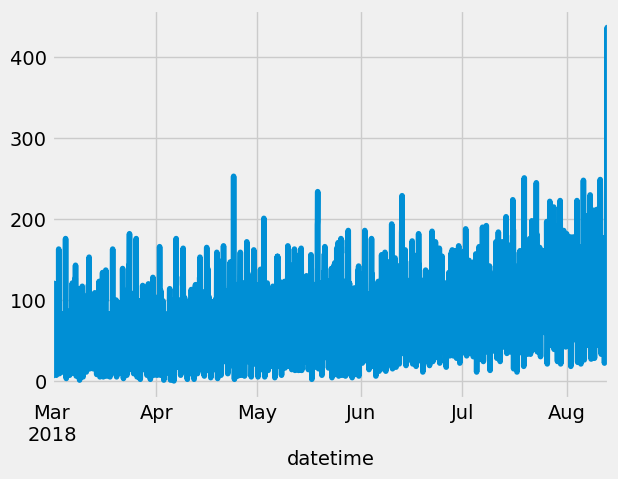

In [12]:
train['num_orders'].plot()

Поскольку ресемплирование выполнялось по 1 часу, то в данном графике сложно что-то распознать, попробуем для построение графика изменить ресемплирование по 1 неделе

<Axes: xlabel='datetime'>

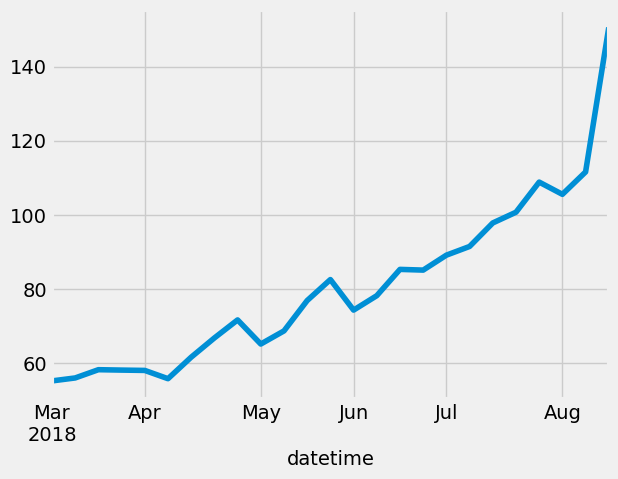

In [13]:
train['num_orders'].resample('1W').mean().plot()

### Скользящее среднее

<Axes: xlabel='datetime'>

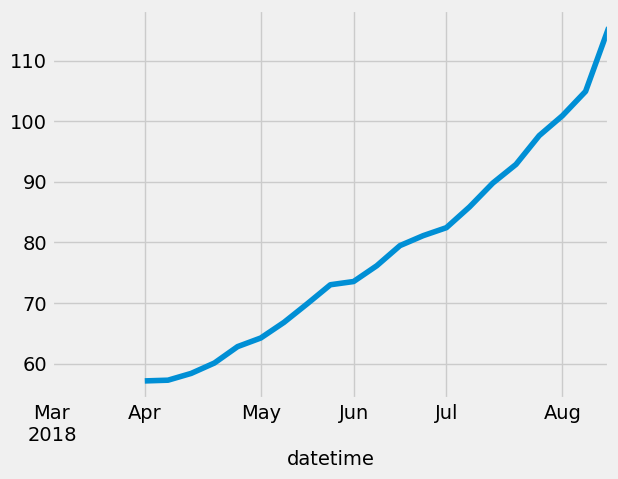

In [14]:
train['num_orders'].resample('1W').mean().rolling(5).mean().plot()

### Тренды и сезонность

**Тренд** (англ. trend) — плавное изменение среднего значения ряда без повторяющихся закономерностей. Например, ежегодное увеличение объёма продаж авиабилетов.

**Сезонность** (англ. seasonality) — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж авиабилетов летом.

Тренды и сезонность зависят от масштаба данных.

Для ресемлпирования возьмем по 1 дню

In [15]:
train['num_orders'].resample('1H').mean().fillna(method='ffill').isna().mean()

0.0

In [16]:
decomposed = seasonal_decompose(train['num_orders'].resample('1H').mean().fillna(method='ffill'))

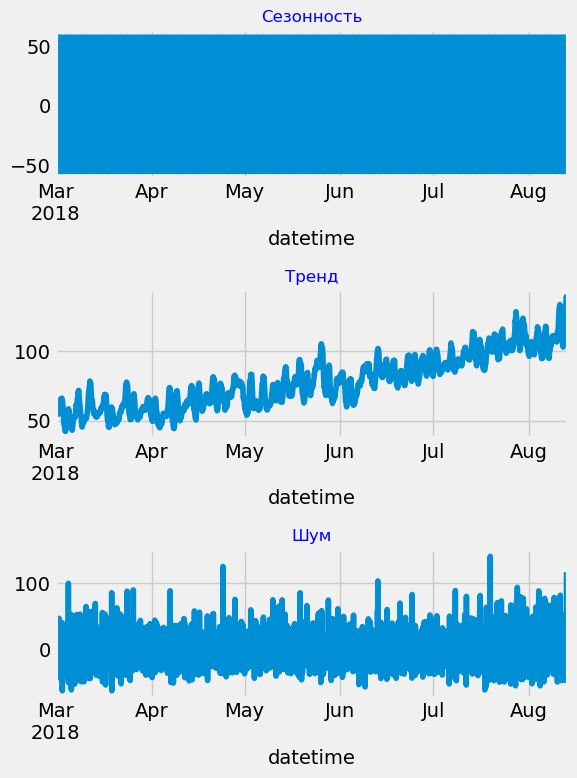

In [17]:
plt.figure(figsize=(6, 8))
plt.tight_layout(h_pad=1)
plt.subplot(311)
plt.title('Сезонность', fontsize=12, color='blue')
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.seasonal.plot(ax=plt.gca())
plt.subplot(312)
plt.title('Тренд', fontsize=12, color='blue')
decomposed.trend.plot(ax=plt.gca())
plt.subplot(313)
plt.title('Шум', fontsize=12, color='blue')
decomposed.resid.plot(ax=plt.gca())
plt.tight_layout();

# Таблица для результатов

In [18]:
rating = pd.DataFrame(columns=['rmse_train',
                               'time_fit_train'])



def estimated_model(gcv, name_model):
    
    a = pd.DataFrame(gcv.cv_results_)
    time_fit_train = a[a['mean_test_score'] == gcv.best_score_]['mean_fit_time'].values[0]


    gcv_best_model = gcv.best_estimator_.predict(train[X])

    rmse_train = gcv.best_score_*-1


        
    rating.loc[len(rating.index)] = [rmse_train, time_fit_train]
    rating.rename(index={(len(rating.index)-1): name_model}, inplace=True)
    


# Создание новых признаков

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    # копируем dataframe
    data = df.copy(deep=True)
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for i in range(max_lag):
        data[f'lag_{i+1}'] = data['num_orders'].shift(i+1)
        
    # Чтобы не учитывать текущее значение, вызовите метод shift():
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
#    возвращаем копию dataframe c измененными признаками
    return data
    

После очищения train создадим на нем новые признаки

In [20]:
train = make_features(train, 24, 24)


In [21]:
train

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,13,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,134.041667
2018-08-13 10:00:00,156,13,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,135.250000
2018-08-13 11:00:00,144,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,137.250000


Удалим пропуски в train

In [22]:
train = train.dropna()

Создадим новые признаки для test

In [23]:
test = make_features(test, 24, 24)


In [24]:
test.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-13 15:00:00,175,13,0,102.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-13 16:00:00,144,13,0,175.0,102.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-13 17:00:00,152,13,0,144.0,175.0,102.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-13 18:00:00,104,13,0,152.0,144.0,175.0,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заполним пропуски медианой по столбцу

In [25]:
def fill_features(df, max_lag):
    # копируем dataframe

    for i in range(max_lag):
        df[f'lag_{i+1}'] = df[f'lag_{i+1}'].fillna(train[f'lag_{i+1}'].median())
    
        
    # Чтобы не учитывать текущее значение, вызовите метод shift():
    df['rolling_mean'] = df['rolling_mean'].fillna(train['rolling_mean'].median())
    
    

In [26]:
fill_features(test, 24)

# Pipeline 

1. Масштабирование данных
2. Категоризация данных - Дни недели категоризуем
3. Модель

In [27]:
train.head(3)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000


In [28]:
train.columns

Index(['num_orders', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object')

In [29]:
numeric = ['lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean']
categorial = ['day', 'dayofweek']

теперь пишем отдельно трансформеры для каждого типа

In [30]:
numeric_transformer = Pipeline(steps=[
                ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
            ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric),
                ('cat', categorical_transformer, categorial)
            ])



pipe = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('model', LinearRegression())
])

In [31]:
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'rolling_mean']),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['day', 'dayofweek'])])),
                ('model', LinearRegression())])

# Обучение

Теперь построим модели для прогнозирования временного ряда, а затем на основании RMSE на train выберем лучшую.

Напишем функцию RMSE:

In [32]:
def RMSE(x):
    return np.sqrt(x)

In [33]:
train.columns


Index(['num_orders', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object')

In [34]:
X = ['day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean']


y = ['num_orders']

## Baseline

In [35]:
model = DummyRegressor(strategy='median')
model.fit(train[X], train[y])

DummyRegressor(strategy='median')

In [36]:
RMSE(mean_squared_error(train[y], model.predict(train[X])))

38.833872073914605

## Линейная регрессия

In [37]:
numeric_transformer = Pipeline(steps=[
                ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
            ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric),
                ('cat', categorical_transformer, categorial)
            ])



pipe = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('model', Ridge())
])

In [38]:
skf = TimeSeriesSplit(n_splits=5)


In [39]:
parameters = {
              'model__alpha': [1.0, 1.1, 1.3],
             }

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf, refit='neg_root_mean_squared_error', scoring='neg_root_mean_squared_error')


In [40]:
gcv.fit(train[X], train[y])

gcv.best_params_

{'model__alpha': 1.3}

In [41]:
gcv.best_score_

-27.188522738632646

In [42]:
estimated_model(gcv, 'Ridge')

In [43]:
rating

,rmse_train,time_fit_train
Ridge,27.188523,0.018752


## Случайный лес

In [44]:
numeric_transformer = Pipeline(steps=[
                ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
            ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric),
                ('cat', categorical_transformer, categorial)
            ])



pipe = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('model', RandomForestRegressor())
])

In [45]:
skf = TimeSeriesSplit(n_splits=5)


In [46]:
parameters = {
              'model__min_samples_leaf': range(2, 4),
              'model__max_depth': range(11, 14),
                'model__n_estimators' : [150]
             }

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf, refit='neg_root_mean_squared_error', scoring='neg_root_mean_squared_error')


In [47]:
gcv.fit(train[X], train[y])

gcv.best_params_

C:\ProgramData\anaconda3\lib\site-packages\imblearn\pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


{'model__max_depth': 12,
 'model__min_samples_leaf': 3,
 'model__n_estimators': 150}

In [48]:
pd.DataFrame(gcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_leaf,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.729892,2.060359,0.034378,0.006249,11,2,150,"{'model__max_depth': 11, 'model__min_samples_l...",-22.480710,-22.804008,-24.736142,-26.498929,-33.785432,-26.061045,4.124084,6
1,4.165167,1.936452,0.034379,0.006253,11,3,150,"{'model__max_depth': 11, 'model__min_samples_l...",-22.307728,-22.736951,-24.654567,-26.386421,-33.751288,-25.967391,4.154925,5
2,4.665708,2.192909,0.025003,0.007656,12,2,150,"{'model__max_depth': 12, 'model__min_samples_l...",-22.569532,-22.379579,-24.546308,-26.276520,-33.735183,-25.901424,4.167727,4
3,4.319782,2.004585,0.021877,0.007654,12,3,150,"{'model__max_depth': 12, 'model__min_samples_l...",-22.308082,-22.499668,-24.501437,-26.259490,-33.735397,-25.860814,4.193688,1
4,4.541946,1.920852,0.025431,0.005832,13,2,150,"{'model__max_depth': 13, 'model__min_samples_l...",-22.444574,-22.510538,-24.462184,-26.392058,-33.628312,-25.887533,4.134341,2
5,3.995456,1.630416,0.024860,0.006011,13,3,150,"{'model__max_depth': 13, 'model__min_samples_l...",-22.233643,-22.557359,-24.731571,-26.316733,-33.621429,-25.892147,4.141847,3


In [49]:
estimated_model(gcv, 'Random_Forest')

In [50]:
rating

,rmse_train,time_fit_train
Ridge,27.188523,0.018752
Random_Forest,25.860814,4.319782


## SVR

In [51]:
numeric_transformer = Pipeline(steps=[
                ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
            ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric),
                ('cat', categorical_transformer, categorial)
            ])



pipe = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('model', SVR())
])

In [52]:
skf = TimeSeriesSplit(n_splits=5)


In [53]:
parameters = {
              'model__degree': [3, 4],
             }

gcv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=skf, refit='neg_root_mean_squared_error', scoring='neg_root_mean_squared_error')


In [54]:
gcv.fit(train[X], train[y])

gcv.best_params_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'model__degree': 3}

In [55]:
gcv.best_score_

-41.26336186192195

In [56]:
estimated_model(gcv, 'SVR')

In [57]:
rating

,rmse_train,time_fit_train
Ridge,27.188523,0.018752
Random_Forest,25.860814,4.319782
SVR,41.263362,0.297366


## CatBoost

In [58]:
feature = ['day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean']

target = ['num_orders']

cat_feature = ['day', 'dayofweek']

In [59]:
train_data = Pool(data=train[feature],
                 label=train[target],
                 cat_features=cat_feature)

test_data = Pool(data=test[feature],
                label=test[target],
                cat_features=cat_feature)

In [60]:
params = {'verbose' : 100,
         'eval_metric' : 'RMSE',
         'loss_function' :'RMSE',
         'random_seed' : RS_CONST,
         'learning_rate':  0.07}

In [61]:
cv_data = cv(params=params,
            pool=train_data,
            fold_count=3,
            shuffle=False,
            partition_random_seed=RS_CONST,
            stratified=True,
            verbose=False,
            type='TimeSeries')

Training on fold [0/3]

bestTest = 23.9572008
bestIteration = 310

Training on fold [1/3]

bestTest = 24.16612842
bestIteration = 936

Training on fold [2/3]

bestTest = 31.48513355
bestIteration = 678



In [62]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]['test-RMSE-mean'].values[0]

26.610718900081157

In [63]:
cv_data

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,88.475937,16.520268,66.908393,6.234572
1,1,83.923970,15.737098,62.995214,5.780395
2,2,79.904229,15.045951,59.415964,5.337328
3,3,76.118403,14.164009,56.141008,4.950094
4,4,72.547825,13.454935,53.093015,4.521443
...,...,...,...,...,...
995,995,26.646145,4.245209,5.121137,2.759687
996,996,26.647882,4.252757,5.112593,2.756911
997,997,26.645531,4.249149,5.105754,2.754318
998,998,26.646679,4.250998,5.098642,2.750662


In [64]:
rating.loc[len(rating.index)] = [cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]['test-RMSE-mean'].values[0], 
                                 np.nan]
rating.rename(index={(len(rating.index)-1): 'Catboost'}, inplace=True)

# Выбор лучшей модели и тестирование

In [65]:
rating

,rmse_train,time_fit_train
Ridge,27.188523,0.018752
Random_Forest,25.860814,4.319782
SVR,41.263362,0.297366
Catboost,26.610719,NaN


По итогу, лучшее качество показал CatBoost, проверим качество модели на test

In [66]:

start_1 = time.time()
params = {
         'learning_rate' : 0.07,
         'verbose' : 100,
         'random_seed' : RS_CONST,
         'eval_metric' : 'RMSE',
         'loss_function' : 'RMSE'}


model = CatBoostRegressor(**params)

model.fit(train_data, plot=True)

end_1 = time.time() - start_1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 37.4709416	total: 19.6ms	remaining: 19.6s
100:	learn: 21.7583013	total: 1.68s	remaining: 15s
200:	learn: 19.3041508	total: 3.3s	remaining: 13.1s
300:	learn: 17.2500444	total: 4.97s	remaining: 11.5s
400:	learn: 15.5647174	total: 6.68s	remaining: 9.98s
500:	learn: 14.3546572	total: 8.43s	remaining: 8.39s
600:	learn: 13.3079722	total: 10.1s	remaining: 6.73s
700:	learn: 12.4647246	total: 11.8s	remaining: 5.03s
800:	learn: 11.6464090	total: 13.4s	remaining: 3.34s
900:	learn: 10.9169891	total: 15.2s	remaining: 1.67s
999:	learn: 10.2529325	total: 16.9s	remaining: 0us


In [67]:
RMSE(mean_squared_error(test['num_orders'], model.predict(test[feature])))

42.06390357509271

In [68]:
start_2 = time.time()
RMSE = RMSE(mean_squared_error(test['num_orders'], model.predict(test[feature])))
end_2 = time.time() - start_2

In [69]:
print('Вребя предсказания на test', end_2)
print('RMSE на test', RMSE)

Вребя предсказания на test 0.0049991607666015625
RMSE на test 42.06390357509271
